
# How To Use Varix
Varix is our implementation of a variational autoencoder.  
This tutorial follows the structure of our `Getting Started - Vanillix`, but is much less extenisve, because
our pipeline works similar for different architecture, so here we focus only on Varix specifics.

**AUTOENCODIX** supports far more functionality than shown here, so we’ll also point to advanced tutorials where relevant.  

**IMPORTANT**

> This tutorial only shows the specifics of the Varix pipeline. If you're unfamilar with general concepts,  
> we recommend to follow the `Getting Started - Vanillix` Tutorial first.

---
## What You'll Learn

You’ll learn how to:

1. **Initialize** the pipeline and run the pipeline. <br> <br>
2. Understand the Varix sepecific **pipeline steps**. <br><br>
3. Access the Varix specific **results** (mus, sigma ,kl/mmd losses). <br><br>
4. **Visualize** outputs effectively. <br><br>
5. Apply **custom parameters**. <br><br>
6. **Save, load, and reuse** a trained pipeline. <br><br>

---

Let’s get started! 🚀

## 1) Initialize and Run Varix
We set a few custom parameters of the config file. For a deep dive into the config object see: 

`Tutorials/DeepDives/ConfigTutorial.ipynb`

In [ ]:
from autoencodix.utils.example_data import EXAMPLE_MULTI_SC
from autoencodix.configs.varix_config import VarixConfig
from autoencodix.configs.default_config import DataCase
import autoencodix as acx

# Varix has its own config class
# with an addtional loss term: either Kulback-Leibler or Maximum Mean Discrepancy 
# instead of passing a pandas DataFrame, we use a pre-defined DataPackage object directly.
# this time with single cell data
print("Input data:")
print(EXAMPLE_MULTI_SC)
print("-" *50)
my_config = VarixConfig(
    learning_rate=0.001,
    epochs=33,
    checkpoint_interval=5,
    default_vae_loss="kl", # kl or mmd possible
    data_case=DataCase.MULTI_SINGLE_CELL,
)
print("\n")
print("Starting Pipeline")
print("-"*50)
print("-"*50)
varix = acx.Varix(data=EXAMPLE_MULTI_SC, config=my_config)
result = varix.run()

Input data:
multi_sc:
  multi_sc: 1000 samples × 700 features
--------------------------------------------------


Starting Pipeline
--------------------------------------------------
--------------------------------------------------
in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
datapackge in process_multi_single_cell multi_sc:
  multi_sc: 1000 samples × 700 features and multi_sc: {'multi_sc': MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'}
mudata: View of MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
--- Running Pairing-Aware Split ---
Identified 1000 fully paired samples across all modalities.
Identified 0 s

## 2) Specific Varix steps
The pipeline (run) does not have Varix specific steps.  
It calls:
- preprocess
- fit
- predict
- and visualize

However, the fit step works slighly different, because we have a second loss term for the distribution loss.  
This loss term can be weighted with a hyperparam `beta` (can be set via config) and the weighting can be changed during the training depending on the epoch via beta annealing.  

Since we're working with a variational autoencoder, we can call an addtional pipeline step `sample_latent_space`. The latent space inside the pipeline is sampled once from the fitted normal distribution, with one set of `mu` and `sigma` per latent dimension.

Per default we sample from the trained model and with the test data, but you can specify the split and epoch.

**ATTENTION**   <br><br>
>If you want to sample from a different split (uses that from that split as input) or epoch (uses model at this epoch), you need to be sure to select an epoch that you checkpoint in (see `checkpoint_interval` config parameter)

In [2]:
print(f"Annealing Strategy for training was: {my_config.anneal_function}")
print(f"beta hyperparam was set to: {my_config.beta}")
print("\n")
print("Starting sampling different latent spaces")
print("-"*50)
latent_spaces = {}
for i in range (4):
    latent_spaces[i] = varix.sample_latent_space()

# or
sampled = varix.sample_latent_space(split="train", epoch=4)
sampled

Annealing Strategy for training was: logistic-mid
beta hyperparam was set to: 0.1


Starting sampling different latent spaces
--------------------------------------------------


tensor([[ 1.8605e+00,  5.9503e-01,  2.8633e+00,  ..., -3.3295e-01,
          3.6397e-01, -3.0647e-01],
        [ 2.0219e+00,  8.6689e-02,  2.0579e+00,  ...,  3.3459e-01,
         -2.2685e+00,  6.3512e-01],
        [-1.5177e+00,  1.7143e+00,  1.1598e+00,  ..., -3.2159e-01,
          4.9689e-01, -1.2166e-03],
        ...,
        [ 8.4792e-01, -9.3708e-01,  5.2105e-01,  ..., -3.9077e-01,
          1.1235e+00,  2.3216e-01],
        [ 1.3911e+00,  7.8915e-01, -9.3846e-01,  ..., -2.1525e+00,
          3.7815e-01,  1.5254e-01],
        [ 3.9820e-01,  8.1112e-01, -6.5058e-01,  ...,  5.6177e-01,
         -5.8660e-01,  4.1995e-01]], device='mps:0')

## 3) Inspect Varix Specific Results
In addtion to the results that the Vanillix pipeline provided, we can access:
- fitted distribution parameters `mu` and `sigma`
- `total`, `reconstruction` and `vae` losses
- `anneal_factor` for 

A note to the different loss types:
For our variation autoencoder, the total loss consists of a reconstruction loss and a distribution loss i.e. kl-divergence. To investigate these losses, the result_obj has the attribute `sub_losses`. This is a `LossRegistry` withe the name of the loss as key and the value is of class `TrainingDynamics` and can be accessed as shown for the Vanillix part.  

For more details check `Tutorials/DeepDives/PipelineOutputTutorial.ipynb`

In [3]:
sub_losses = result.sub_losses
print("Sub Losses:")
print(f"keys: {sub_losses.keys()}")
print("\n")
recon_dyn = sub_losses.get(key="recon_loss")
print("Value of reconstruction loss in epoch 4 for train split")
print(recon_dyn.get(split="train", epoch=4))

Sub Losses:
keys: dict_keys(['recon_loss', 'var_loss', 'anneal_factor', 'effective_beta_factor'])


Value of reconstruction loss in epoch 4 for train split
22.430706874302455


In [4]:
mu = result.mus.get(split="valid", epoch=9)
mu

array([[0.46294594, 0.59931517, 0.31728157, ..., 0.28357047, 0.        ,
        0.        ],
       [0.        , 0.12387601, 0.48154515, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.09632568, 0.68376935, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.20526107, 0.76571673, 0.7445091 , ..., 0.        , 0.        ,
        0.32879898],
       [0.57973206, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.4198662 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

## 4) Show Visualizations

This follows the standard pipeline process and can be done by calling `show_result()`.  
We see a loss plot for each loss type.

Creating plots ...


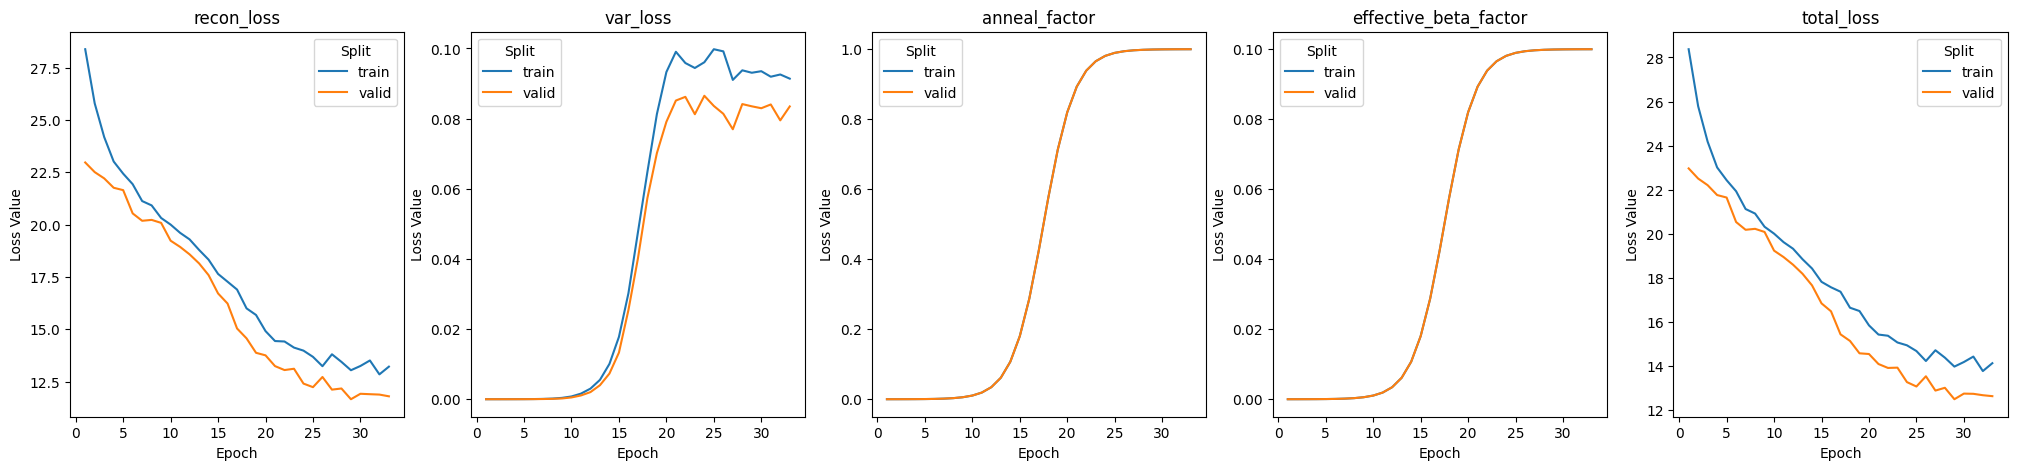

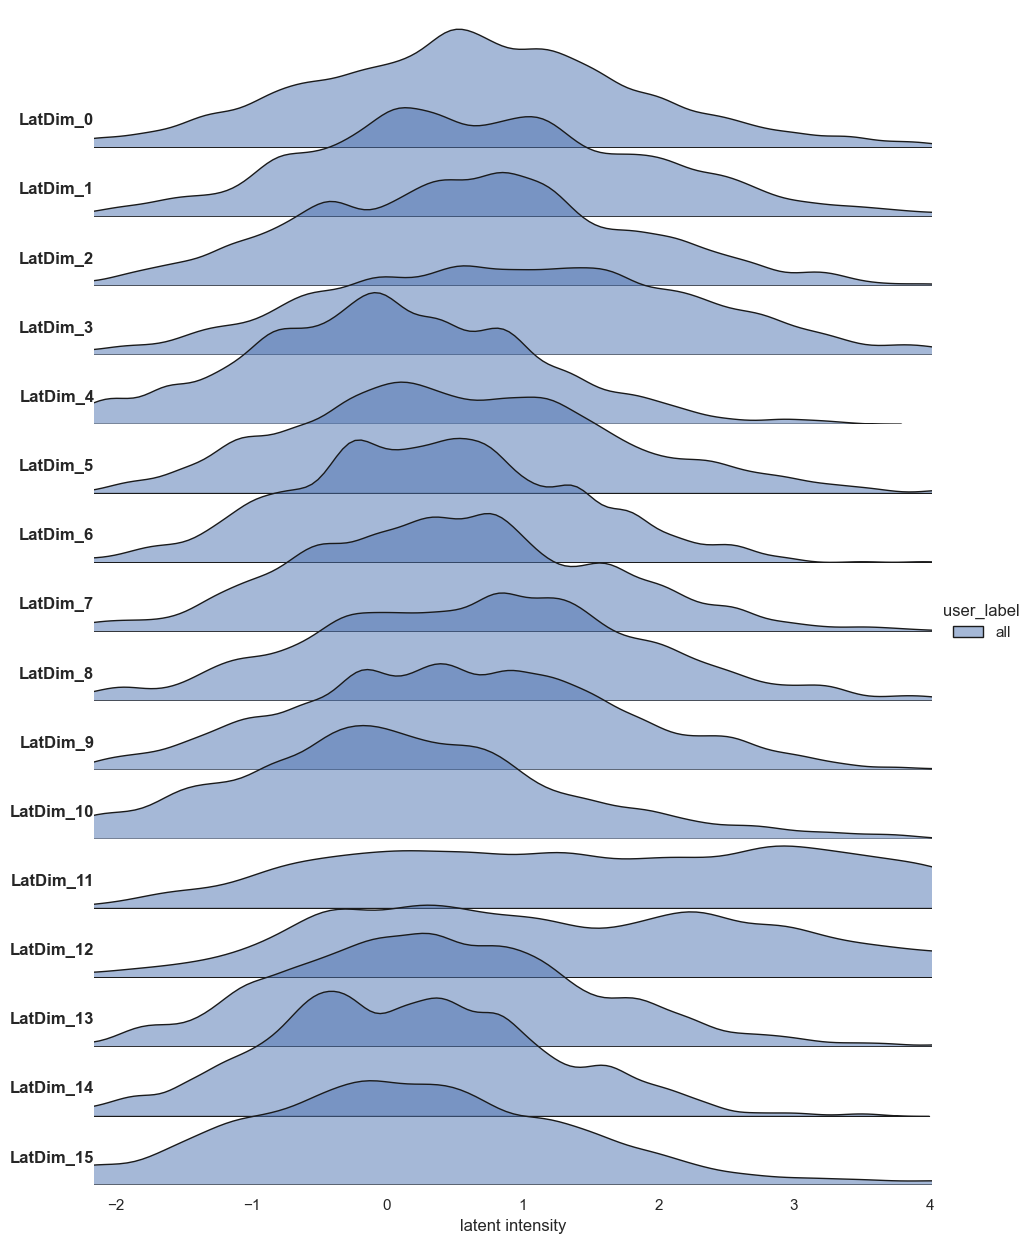

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


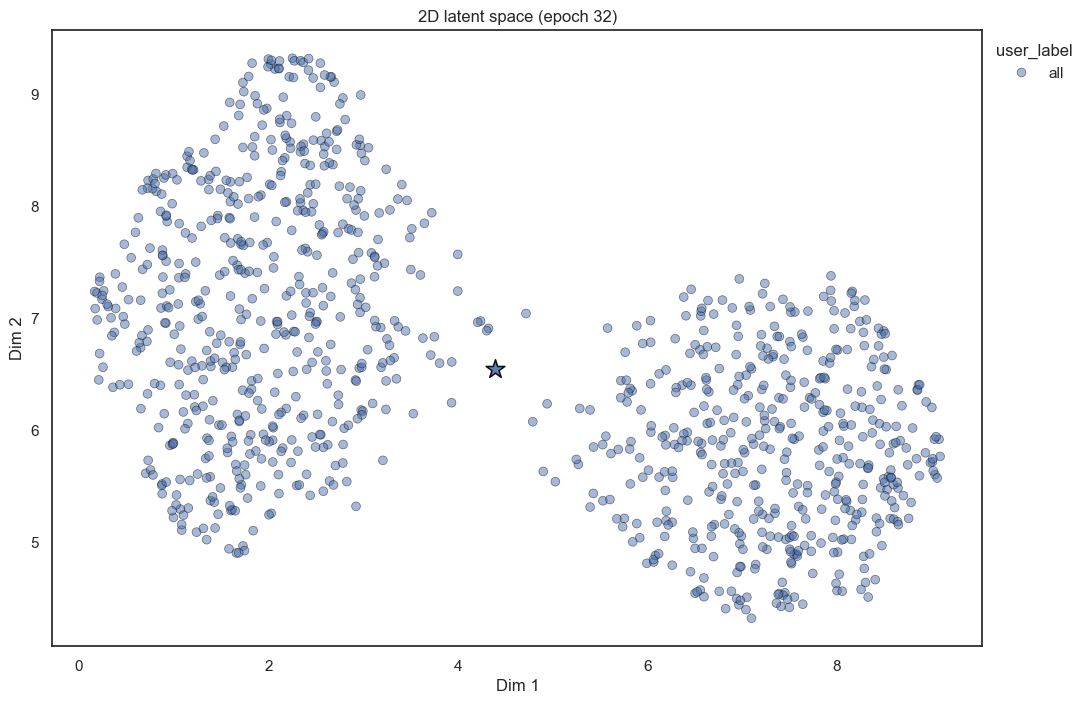

In [5]:
varix.show_result()

## 5) Customize Varix


To customize the behavior of our pipeline, you adjust the configuration.  
There are two ways to work with the config:

1. Create a customized instance of the config class.  
2. Provide a `yaml` file and use the config class to read it.  

We will focus on option 1 and show a few examples. For a deeper dive into configurations, please refer to `Tutorials/DeepDives/ConfigTutorial.ipynb` <br>

In this section, we demonstrate some Varix specific params:
- loss term  
- beta
- annealing strategy
- Retrieve information about all config parameters  




In [12]:
from autoencodix.configs import VarixConfig
custom_config = VarixConfig(default_vae_loss="mmd", beta=1.5, anneal_function="logistic-late", data_case=DataCase.MULTI_SINGLE_CELL)
custom_varix = acx.Varix(config=custom_config, data=EXAMPLE_MULTI_SC)
result = custom_varix.run()

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
datapackge in process_multi_single_cell multi_sc:
  multi_sc: 1000 samples × 700 features and multi_sc: {'multi_sc': View of MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'
      uns:	'log1p'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'
      uns:	'log1p'}
mudata: View of MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'
      uns:	'log1p'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'
      uns:	'log1p'
--- Running Pairing-Aware Split ---
Identified 1000 fully paired samples across all modalities.
Identified 0 samples present in at least one, but not all, modalities.
Successfully generated synchronized indices for al


## 6) Re-use, Save, Load
There are not `Varix` specific steps here. See the `Getting Started - Vanillix` for details. Below is a basic save/load usecase

In [ ]:
import os
import glob

outpath = os.path.join("tutorial_res", "varix.pkl")
varix.save(file_path=outpath)

folder = os.path.dirname(outpath)
pkl_files = glob.glob(os.path.join(folder, "*.pkl"))
model_files = glob.glob(os.path.join(folder, "*.pth"))

print("PKL files:", pkl_files)
print("Model files:", model_files)

# the load functionality automatically will build the pipeline object out of the three saved files
varix_loaded = acx.Varix.load("varix.pkl")

Pipeline object saved successfully.
Preprocessor saved successfully.
Model state saved successfully.
PKL files: ['tutorial_res/varix.pkl_preprocessor.pkl', 'tutorial_res/varix.pkl', 'tutorial_res/van.pkl_preprocessor.pkl', 'tutorial_res/van.pkl']
Model files: ['tutorial_res/varix.pkl_model.pth', 'tutorial_res/van.pkl_model.pth']
Attempting to load a pipeline from van.pkl...
Pipeline object loaded successfully. Actual type: Vanillix
Preprocessor loaded successfully.
Model state loaded successfully.
